In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pygplates
import pygmt

from gprm import ReconstructionModel
from gprm.datasets import Rocks, Reconstructions, Paleogeography, Geology
from gprm.utils.raster import to_anchor_plate

import sys
sys.path.append('/Users/simon/OneDrive/Andes_works//python/')
import joyful_geochemistry as joy
import joyful_mapping as joymap

import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2


############## Settings for Scotese Paleomap
PaleomapDictionary = {}
PaleomapDictionary['name'] = 'Paleomap'
PaleomapDictionary['reconstruction_model'] = Reconstructions.fetch_Scotese()
PaleomapDictionary['raster_sequence'] = Paleogeography.fetch_Paleomap()
PaleomapDictionary['maximum_time'] = 350.

#Paleomap = Reconstructions.fetch_Scotese()
#PaleoDEM = Paleogeography.fetch_Paleomap()


############## Settings for Boschman model
boschman_rotation_model = ReconstructionModel('')
boschman_rotation_model.add_rotation_model('/Users/simon/GIT/bx/andes//boschman/reconstruction_model/boschman_reverse_engineered_rotations.rot')
boschman_rotation_model.add_static_polygons('/Users/simon/GIT/bx/andes//boschman/reconstruction_model/reconstructed_0.00Ma.shp')

raster_dict = {}
for reconstruction_time in np.arange(0,81,1):
    raster_dict[reconstruction_time] = '/Users/simon/GIT/bx/andes//boschman/grids/boschman_DEM_{:0.0f}Ma.nc'.format(reconstruction_time)
boschman_rasters = collections.OrderedDict(sorted(raster_dict.items()))


BoschmanDictionary = {}
BoschmanDictionary['name'] = 'Boschman'
BoschmanDictionary['reconstruction_model'] = boschman_rotation_model
BoschmanDictionary['raster_sequence'] = boschman_rasters
BoschmanDictionary['maximum_time'] = 80.


########## Geochemistry Inputs
df = joy.geochem_from_csv('../datafiles/geochem_merge_20221026.csv')

model_dir = '../luffi/REM_surfaces_csv/'
gc_interpolator_dict = joy.make_gc_interpolator_dict(model_dir)



ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


<Axes: >

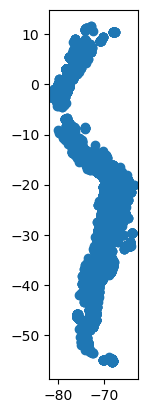

In [5]:
df = joymap.select_orogens(df,gdf=None, 
                           orogen_names='Cordilleran', 
                           continent_names='South America',
                           region=[-100, -50, -60, 20])


pilger_volcanics = joymap.load_pilger_volcanics('/Users/simon/OneDrive/Andes_works//datafiles/2022-2-NGG0Q7_Pilger_Andean-Igneous-Radiometric-Dates.xlsx')

df.plot()

Number of samples after basic filtering 19309
Final number of samples passed = 19309
TODO implement min/max elevation cutoffs
0.0


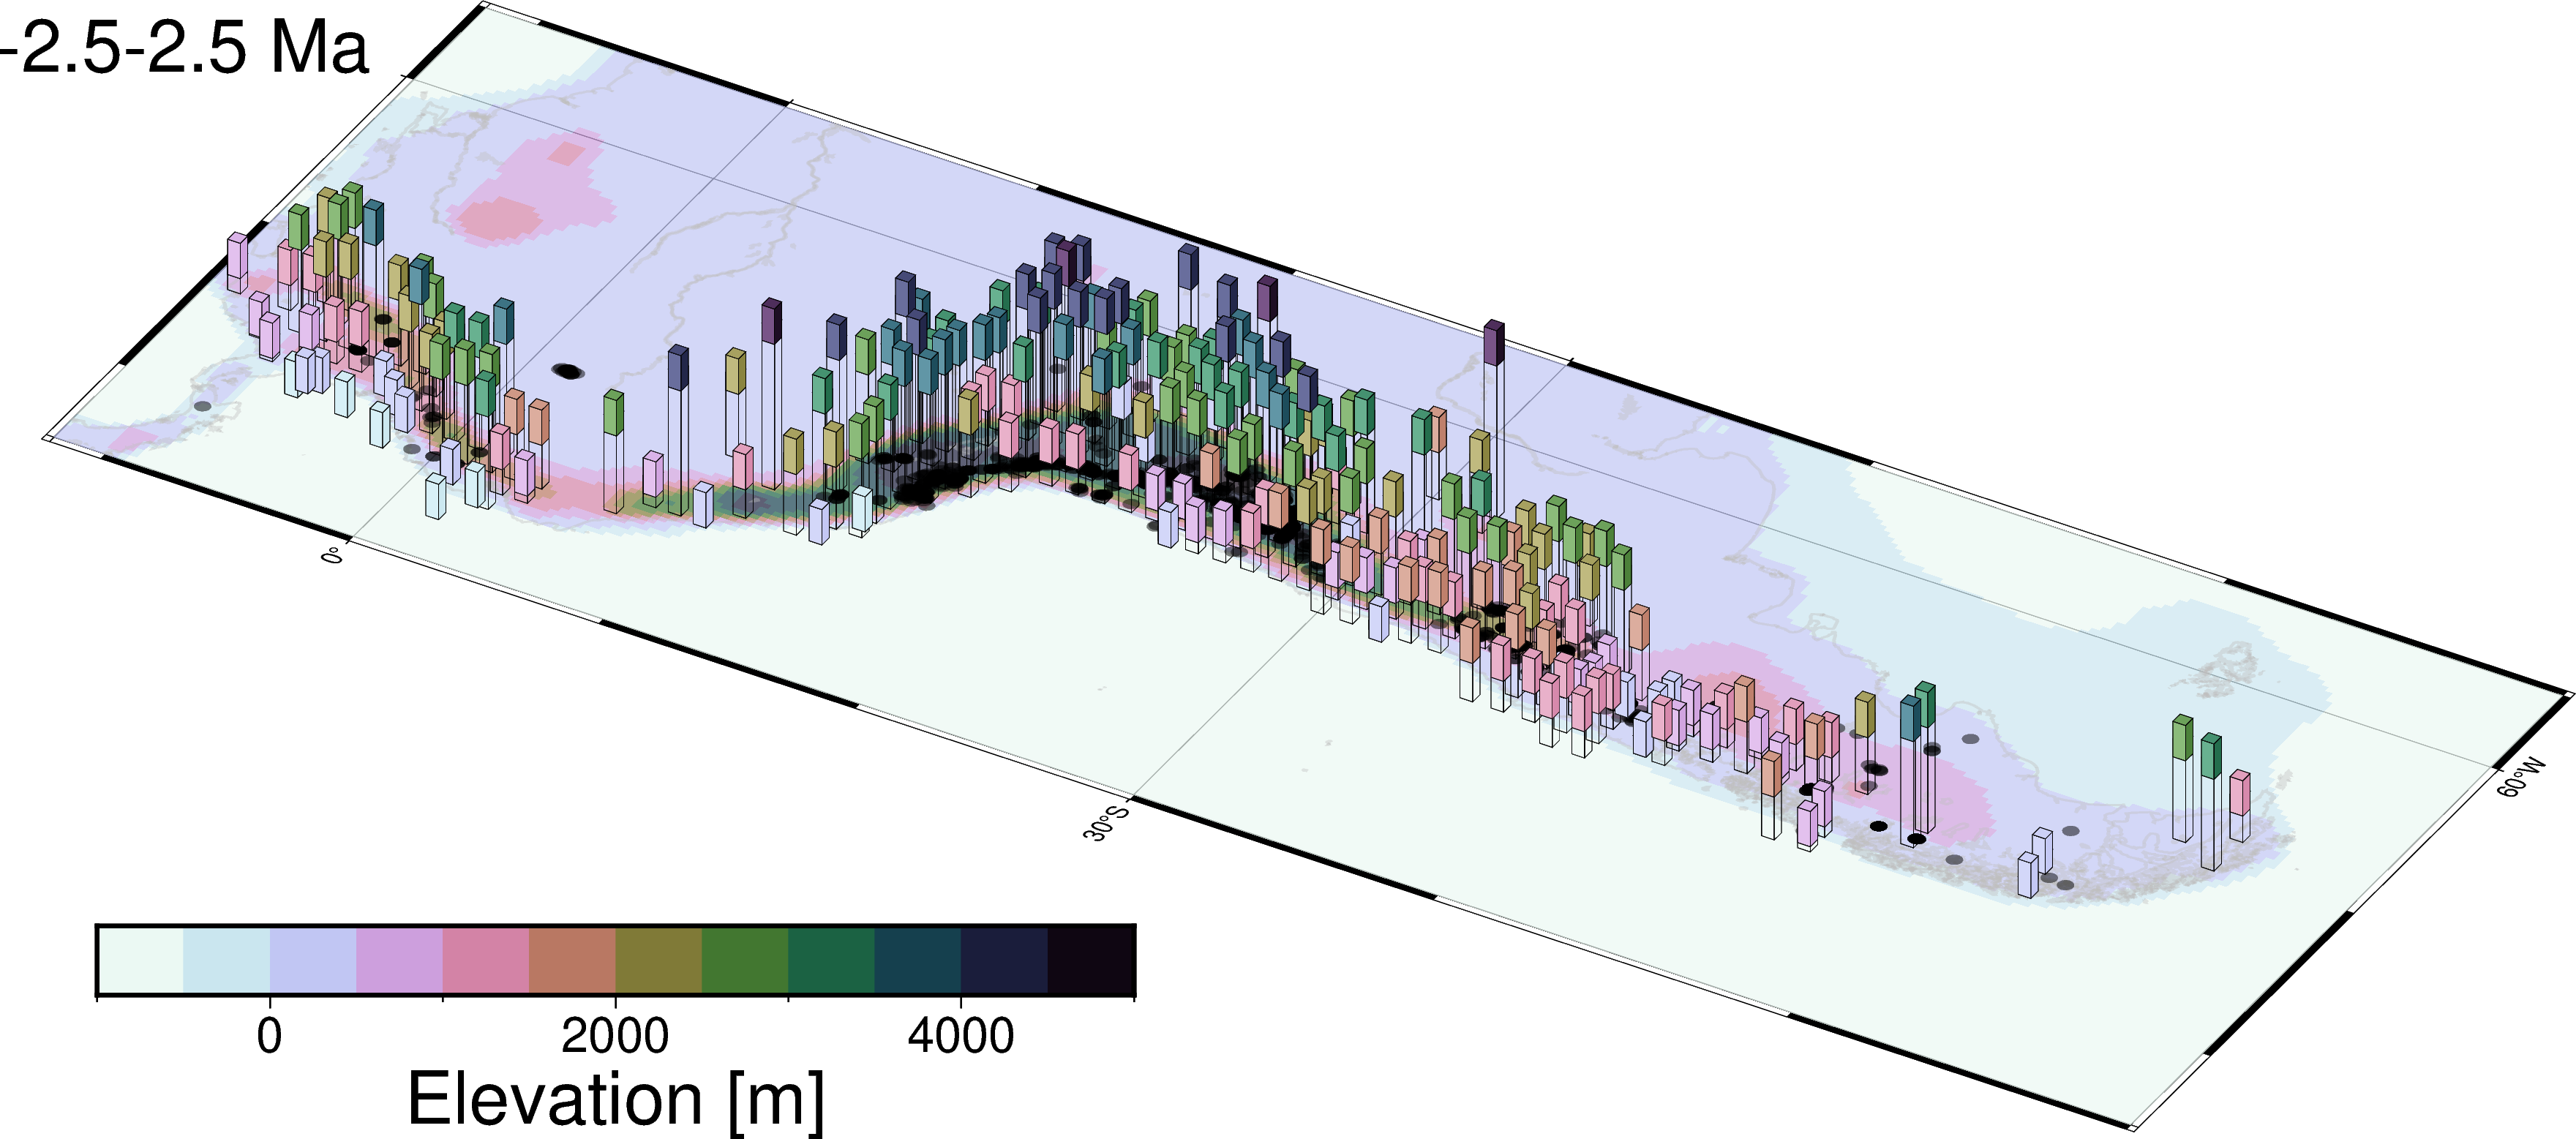

Number of samples after basic filtering 19309
Final number of samples passed = 19309
TODO implement min/max elevation cutoffs


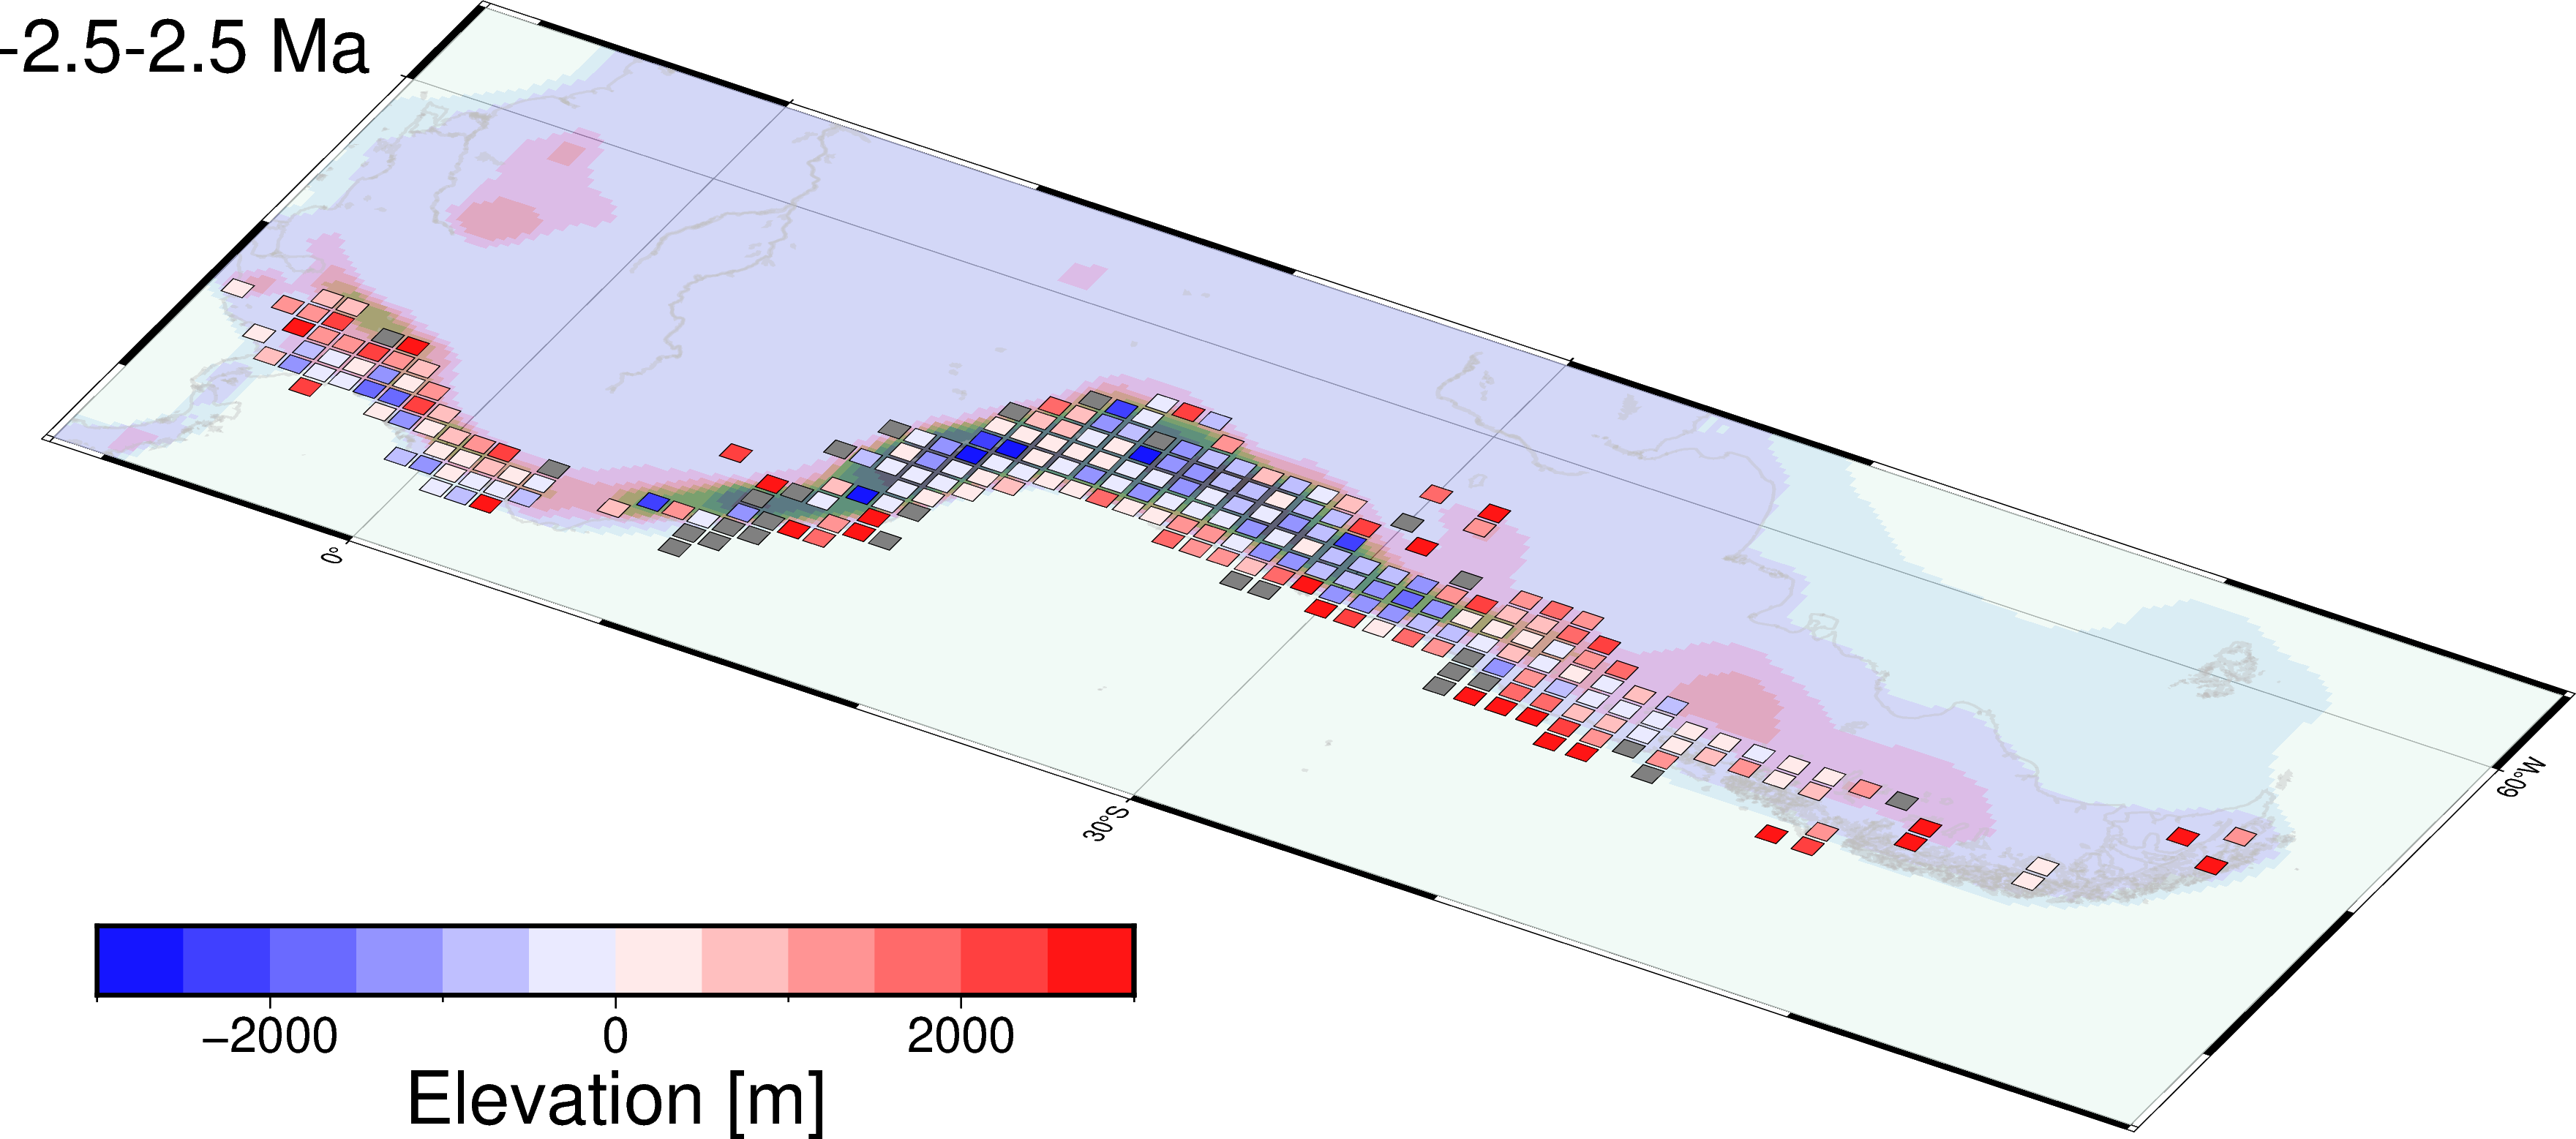

In [6]:
region = [-85, -55, -58, 12]
#region = [-76, -66, -25, -12]
projection="M10c"
perspective = [240, 35]

time_bin_size = 5.
space_bin_size = 1.

#calibration = 'Hu'
#mohometer_selection = ['la_yb_elevation']

calibration = 'luffi'
mohometer_selection = 10


MODEL = PaleomapDictionary

reconstruction_model = MODEL['reconstruction_model']
raster_sequence = MODEL['raster_sequence']




if isinstance(mohometer_selection, list):
    mohometer_description_string = '|'.join(mohometer_selection)
else:
    mohometer_description_string = str(mohometer_selection)

    
    
for reconstruction_time in np.arange(0,MODEL['maximum_time'],time_bin_size):
    
    fig = pygmt.Figure()

    binned_elevations = joymap.timeslice_plot(df, reconstruction_time,
                                              time_bin_size, space_bin_size, 
                                              fig, raster_sequence, reconstruction_model, anchor_plate_id=201,
                                              gc_interpolator_dict=gc_interpolator_dict, 
                                              calibration=calibration, mohometer_selection=mohometer_selection,
                                              region=region, projection=projection, perspective=perspective, 
                                              volcanics=pilger_volcanics, return_type='binned_elevations')
    
    joymap.add_labels(fig, reconstruction_time, time_bin_size, add_colorbar=True)
    
    #fig.savefig('../images/sequence/elevations_plus_volcanism_{:0.0f}Ma.png'.format(reconstruction_time))
    fig.show(width=1000)
    
    fig = pygmt.Figure()

    binned_residuals = joymap.timeslice_plot(df, reconstruction_time,
                                             time_bin_size, space_bin_size, 
                                             fig, raster_sequence, reconstruction_model, anchor_plate_id=201,
                                             gc_interpolator_dict=gc_interpolator_dict, 
                                             calibration=calibration, mohometer_selection=mohometer_selection,
                                             region=region, projection=projection, perspective=perspective, 
                                             volcanics=None, residuals=True, return_type='binned_residuals')
    
    joymap.add_labels(fig, reconstruction_time, time_bin_size, add_colorbar=True)
    
    #fig.savefig('../images/sequence/elevations_plus_volcanism_{:0.0f}Ma.png'.format(reconstruction_time))
    fig.show(width=1000)
    
    joymap.residuals_crossplot(binned_elevations, binned_residuals,
                               fname='/Users/simon/GIT/bx/andes//images/sequence_b/crossplot_{:s}_{:s}_{:0.1f}Ma.png'.format(calibration,
                                                                                                        mohometer_description_string, 
                                                                                                        reconstruction_time))
    break
    


In [ ]:
    
time_bin_size = 20
space_bin_size = 1.

fig = pygmt.Figure()

for reconstruction_time in np.arange(10,120,time_bin_size): 
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='48c', xshift='32c')
for reconstruction_time in np.arange(130,240,time_bin_size):
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='48c', xshift='32c') 
for reconstruction_time in np.arange(250,360,time_bin_size):
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='4c', xshift='-23c')
with pygmt.config(FONT_ANNOT_PRIMARY='16p', FONT_LABEL='24p'):
    fig.colorbar(position='JBC+jBC+o0c+w32c/1.6c+h', frame=['x+lElevation [m]'])
    
fig.savefig('../images/elevation_vs_paleomap_perspective_Luffi.pdf')
fig.show(width=1000)
